# Practice II Machine Learning
## `Masters Degree in Data Science`
# <font color='orange'>CUNEF</font>
## By Gabriela Gutiérrez-Colomer Santos: g.gutierrezcolomer@cunef.edu
In this Machine Learning Problem we will be presented with a dataset that covers some transaction Frauds dataset_payments_fraud.csv. The objective of this practice is to create a complete study of the dataset and construct some ML models to be able to predict whether a client will commit fraud or not. Throughout this practice, we will analyse the dataset's data and compare the ML models, and finally, we will look at the model's interpretability, an essential part for understanding model predictions.

In [1]:
%%capture
%run 02_MODELS_GGC.ipynb #import the notebook

## Global Agnostic Methods
Permutation Importance
Permutation importance is not an interpretable direct method because it is not a model itself but rather a way of explaining how a model behaves through feature importance. A feature is considered important when, changing the order of the values and performing some prediction, the predictions become a mess (the error of the model increases). With this method, we can understand what is the model using when deciding, for example, if a patient is considered to have a stroke or not. We will perform permutation importance on:

- The Light GBM model
- The Logistic Regression Model

## a. For `LIGHT GBM` Classifier

In [2]:
import warnings
warnings.filterwarnings("ignore")

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0885 ± 0.0003,oldbalanceOrg
0.0670 ± 0.0007,amount
0.0435 ± 0.0004,oldbalanceDest
0.0268 ± 0.0003,type_TRANSFER
0.0229 ± 0.0002,newbalanceOrig
0.0040 ± 0.0002,newbalanceDest
0.0010 ± 0.0001,step
0.0000 ± 0.0000,user_connections
0.0000 ± 0.0000,connection_time
0.0000 ± 0.0000,zone_capital


Te most improtant features are oldbalanceOrg and amount according to permutation importance of the LightGBM model.
If we interpret this, we could understand that for the model to classify a client as committing fraud, when deciding where to "put" the client, the model will rely highly on the amount of the transaction.

## b. For `RandomForest` Classifier

In [3]:
import warnings
warnings.filterwarnings("ignore")

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0304 ± 0.0004,oldbalanceOrg
0.0154 ± 0.0004,amount
0.0081 ± 0.0002,newbalanceOrig
0.0065 ± 0.0004,newbalanceDest
0.0032 ± 0.0001,type_TRANSFER
0.0015 ± 0.0001,step
0.0006 ± 0.0002,oldbalanceDest
0.0001 ± 0.0002,user_connections
0.0001 ± 0.0001,age
0.0001 ± 0.0000,security_alert


Te most improtant features are OldbalanceOrg and amount according to permutation importance of the RandomForest. If we look at the two permutations we can see that they ar epractically the same, they both rely on the same variables to classify the patient as fraud.

## Partial Dependence Plots
Feature importance shows what variables are the most important or which are the varaibles that the model relies on the most, partial dependance plots show how variables affect predictions and also wether the relationship is linear, monotonic or more complex. Partial Dependance Plot (PDP) is a very sophisticated method. The function for partial dependence for regression is:

$$\hat{f}_{s}(x_{S})= E_{X_{C}}[\hat{f}(x_{S}, X_{C})]= \int \hat{f}(x_{S}, X_{C})d \mathbb{P}(X_{c})$$
Partial dependence works by marginalizing the machine learning model output over the distribution of the features in set C (marginalising the variables that we are not going to use for the partial plot), so that the function shows the relationship between the features in set S we are interested in and the predicted outcome.

## Old Balance of Origin Client in `Light GBM` pdp
Lets perform the pdp of the two most important variables of the LighGBM model.

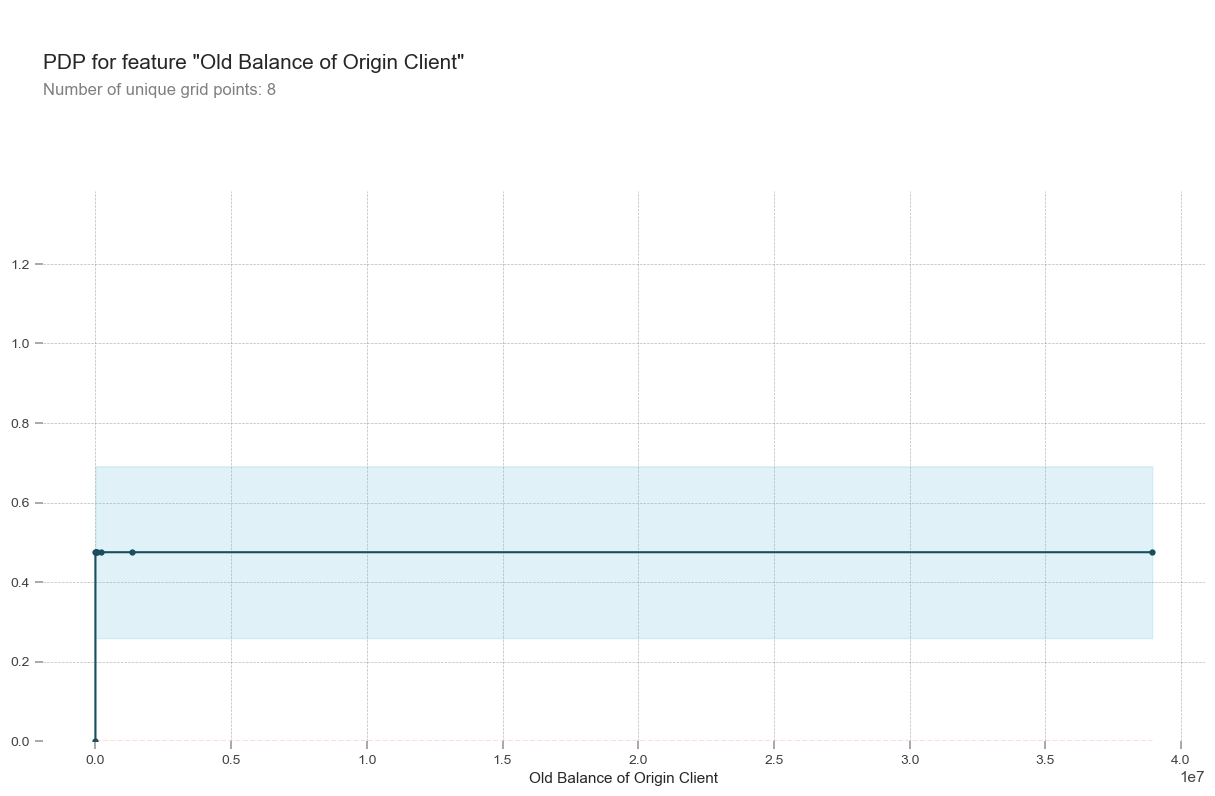

In [4]:
import matplotlib.pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_age = pdp.pdp_isolate(model=clf, dataset=df, 
model_features=feature_names, feature='oldbalanceOrg')
pdp.pdp_plot(pdp_age, 'Old Balance of Origin Client')
plt.show()

As we can see in the graph, having an Old Balance of 0 is going to increase the probabilities of being classified as 1. From 0 on, having a higher Old Balance is not going to going to increase the chances of being classified as 1.

In conclusion, having a 0 Old Balance value will increase your chances of getting classified as 1 but further on will not make you fraud prone.

##  Amount `RandomForest` pdp

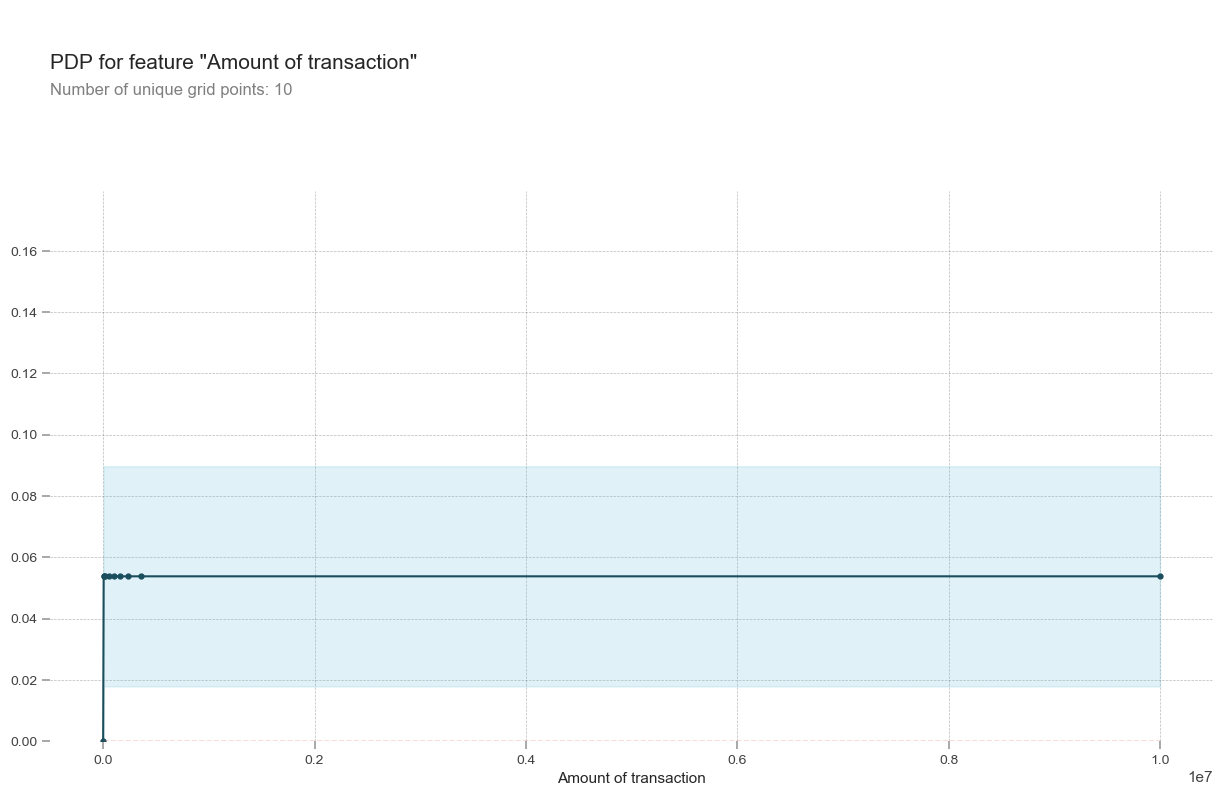

In [5]:
import matplotlib.pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_age = pdp.pdp_isolate(model=rf, dataset=df, 
model_features=feature_names, feature='amount')
pdp.pdp_plot(pdp_age, 'Amount of transaction')
plt.show()

It appears that having an amount of 0 automatically increases the probabilities of being classified as stroke, but then, when the amount of the transaction increases, there is no longer an increase in the probability of bein classified as fraud. Following my intuition, I think the amount is not really what matters but actually the fact that there has been some transactions where the old and new balances where 0 and the the amount was not 0 that were classified as fraud.

## Local Agnostic Methods
### SHAP Values
In this script, we will treat specifically TreeSHAP, TreeSHAP are SHAP values used for decision trees, random forests and gradient boosting. TreeSHAP defines the value function using the conditional expectation 
$E_{X_{S}|{X_{C}}}(\hat{f}(x) | x_{S})$.

Each feature value is a force that either increases or decreases the prediction. The prediction starts from the baseline. The baseline for Shapley values is the average of all predictions. In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. These forces balance each other out at the actual prediction of the data instance.

In [6]:
X_test_shap = pd.DataFrame(X_test)
X_test_shap.columns = list(X.columns)

In [7]:
row_to_show = 50
data_for_prediction = X_test_shap.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
dt_model.predict_proba(data_for_prediction_array)

array([[0.98780488, 0.01219512]])

In [8]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
#%%
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

This client has 0 probabilities of bein calssified as fraud, Why? We can see:

- New balance dest is not 0: remeber we were suspecting from those that had new and old balance 0.
- The original balance was 0, so it seems he/she received money.
- The amount was not 0
- The type was not cash_out, remeber that transfer and cash out where both fraud prone classes.

**Why he could be classified as fraud?**

He did a transfer
Overall why is out model tell us that this client is not commiting fraud? It can be seen because the amount of the transaction is not 0 and the new and old balance of the destin client is not 0. Remember that fraud transactions were thought to be those that had old and new balance dest as 0.

In [9]:
row_to_show = 87
data_for_prediction = X_test_shap.iloc[row_to_show]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
dt_model.predict_proba(data_for_prediction_array)

array([[0.88294574, 0.11705426]])

In [10]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
#%%
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)


**Why does the model think this client has more probabilities of commiting fraud?**

- Because of the transaction type.
- This client has a newbalance origin of 0
- We have to think that, althoug this client has more probabilities of being classified as fraud, the probabilities are still low because of the same reasons that we explained above.

# My advice to professionals that will look for fraud clients will be:
- Be carefull with the amount they manage, if the amount is not 0 and the new and old balance of the destin client is 0 revise it well it could be fraud.
- Transaction type are very important, spend more time in `CC` transactions.
- If the type is Transfer or cash_out be carefull, most of those transactions are fraudulent.
- Having a low step seems to be a signal of no-fraud, however, long transaction hours did not show to mean fraud.